## Gillespie-like Inference in PyProb

In [1]:
import pyprob
from pyprob import Model
from pyprob.distributions import Categorical, Normal, Uniform

import torch
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure();

<Figure size 432x288 with 0 Axes>

Define a multinomial distribution to mimic one step of gillespie. We are interested in doing inference on a rate parameter used in gillespie. The idea is we have a mispecified rate, we can fix this by collecting data and conditioning on it to correct the parameter.

$$X_1, ..., X_n = \text{Multinomial}(\Theta)$$

$$\Sigma_{i=1}^m \Theta_i = 1$$

$$\Theta_i = r_i * \text{Protein}_i$$

But we need the rate $r_i$ to be a random variable so that we can do inference.

Convert $r_i => R_i$ where $R_i \sim N(r_j, \sigma^2)$

Now we can do inference on this random variable. Specify our baysian update rules as follows (Assuming three levels):

$$P(R|D) = P(D|R)P(R)$$

$$P(D|R) = Multinomial(\Theta_1, \Theta_2, f(R))$$

$$P(R) = N(r_j, \sigma^2)$$

### Define Model

In [9]:
pyprob.sample(Categorical([1,2,3]))

tensor(2)

In [28]:
class CategroicalUnknownP3(Model):
    def __init__(self):
        super().__init__(name='Gaussian with unknown mean') # give the model a name
        
        ## Rate parameters we are not interested in
        self.p1_prior = 25
        self.p2_prior = 25
        
        ## rate parameter of interest
        self.p3_prior = 50
        self.p3_std_prior = 5
        
        ## Needed for update rule
        #self.protein = 1.5

    def forward(self): # Needed to specifcy how the generative model is run forward
        # sample the (latent) variable to be inferred:
        prior = pyprob.sample(Normal(self.p3_prior, self.p3_std_prior)) # NOTE: sample -> denotes latent variables
        #prior = prior * self.protein
        
        # define the likelihood
        likelihood = Categorical([self.p1_prior, self.p2_prior, prior])

        # Lets add two observed variables
        # -> the 'name' argument is used later to assignment values:
        pyprob.observe(likelihood, name='obs0') # NOTE: observe -> denotes observable variables
        pyprob.observe(likelihood, name='obs1')

        # return the latent quantity of interest
        return prior
    
model = CategroicalUnknownP3()

In [30]:
def plot_function(min_val, max_val, func, *args, **kwargs):
        x = np.linspace(min_val,max_val,int((max_val-min_val)*50))
        plt.plot(x, np.vectorize(func)(x), *args, **kwargs)

def get_dist_pdf(dist):
    return lambda x: math.exp(dist.log_prob(x))
        
class CorrectDistributions:
    def __init__(self, model):
        self.prior_mean = model.p3_prior
        self.prior_std = model.p3_std_prior
        #self.protein = model.protein
        self.prior_dist = Normal(self.prior_mean, self.prior_std)#* self.protein
        
    @property
    def observed_list(self):
        return self.__observed_list

    @observed_list.setter
    def observed_list(self, new_observed_list):
        self.__observed_list = new_observed_list
    #     self.construct_correct_posterior()

    def prior_pdf(self, model, x):
        p = Normal(model.prior_mean,model.prior_stdd)* self.protein
        return math.exp(p.log_prob(x))

    def plot_posterior(self, min_val, max_val):
        if not hasattr(self, 'posterior_dist'):
            raise AttributeError('observed values are not set yet, and posterior is not defined.')
        plot_function(min_val, max_val, get_dist_pdf(self.posterior_dist), label='correct posterior', color='orange')


    def plot_prior(self, min_val, max_val):
        plot_function(min_val, max_val, get_dist_pdf(self.prior_dist), label='prior', color='green')

correct_dists = CorrectDistributions(model)

### Observe Prior

In [31]:
prior = model.prior_results(num_traces=1000)

Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 1000/1000 | 1000.00 | 2,247.00       


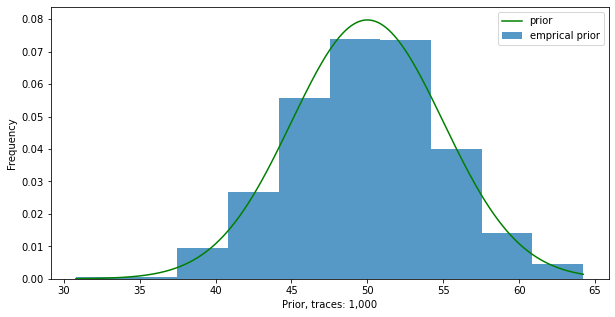

In [32]:
prior.plot_histogram(show=False, alpha=0.75, label='emprical prior')
correct_dists.plot_prior(min(prior.values_numpy()),max(prior.values_numpy()))
plt.legend();
plt.show()

### Run inference using pyprob's NN learning

In [34]:
model.learn_inference_network(num_traces=20000,
                              observe_embeddings={'obs0' : {'dim' : 32},
                                                  'obs1': {'dim' : 32}},
                              inference_network=pyprob.InferenceNetwork.LSTM)

Creating new inference network...
Observable obs0: reshape not specified, using shape torch.Size([]).
Observable obs0: using embedding dim torch.Size([32]).
Observable obs0: observe embedding not specified, using the default FEEDFORWARD.
Observable obs0: embedding depth not specified, using the default 2.
Observable obs1: reshape not specified, using shape torch.Size([]).
Observable obs1: using embedding dim torch.Size([32]).
Observable obs1: observe embedding not specified, using the default FEEDFORWARD.
Observable obs1: embedding depth not specified, using the default 2.
Observe embedding dimension: 64
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Learn.rate| Traces/sec
New layers, address: 16__forward__prior__Normal__1, distribution: Normal
Total addresses: 1, distribution types: 1, parameters: 1,643,583
0d:00:00:22 | 1    | 19,776    | +3.02e+00 | +2.81e+00 | +2.96e+00 | 0d:00:00:14 | +1.00e-03 | 907.9                                 
Stop condi

In [47]:
# sample from posterior (2000 samples)
posterior_nn = model.posterior_results(
                             num_traces=2000, # the number of samples estimating the posterior
                             inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK, # specify which inference engine to use
                             observe={'obs0': torch.tensor(2),
                                      'obs1': torch.tensor(2)} # assign values to the observed values
                             )

Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec
0d:00:00:06 | 0d:00:00:00 | #################### | 2000/2000 | 1983.72 | 305.94       


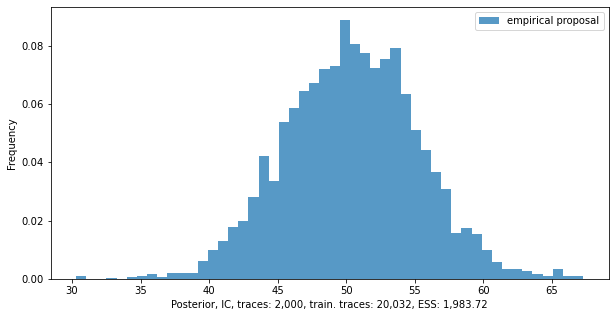

In [48]:
#posterior_unweighted = posterior_nn.unweighted()
posterior_nn.plot_histogram(show=False, bins=50, alpha=0.75, label='empirical proposal')

# correct_dists.plot_posterior(min(posterior.values_numpy()),
#                              max(posterior.values_numpy()))
plt.legend();

In [49]:
posterior_nn.mean

tensor(50.3917)

### Inference with Random Walk MH

In [56]:
# sample from posterior (2000 samples)
posterior = model.posterior_results(
                             num_traces=2000, # the number of samples estimating the posterior
                             inference_engine=pyprob.InferenceEngine.RANDOM_WALK_METROPOLIS_HASTINGS, # specify which inference engine to use
                             observe={'obs0': torch.tensor(2),
                                      'obs1': torch.tensor(2)
                                     } # assign values to the observed values
                             )

Time spent  | Time remain.| Progress             | Trace     | Accepted|Smp reuse| Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 2000/2000 |  83.85% |   0.00% | 1,074.56       


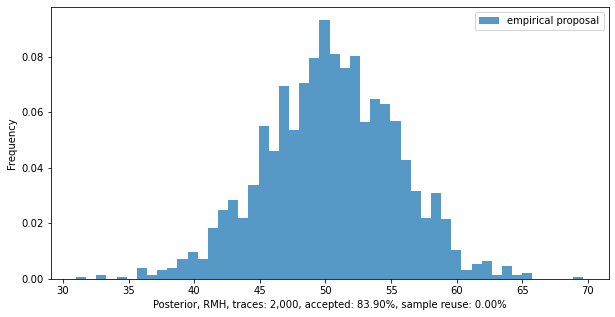

In [57]:
#posterior_unweighted = posterior_nn.unweighted()
posterior.plot_histogram(show=False, bins=50, alpha=0.75, label='empirical proposal')

# correct_dists.plot_posterior(min(posterior.values_numpy()),
#                              max(posterior.values_numpy()))
plt.legend();

In [58]:
posterior.mean

tensor(50.4528)